# Linear Mixed Models

### Set up the environment

In [1]:
%matplotlib inline
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)

import sys
import numpy as np
import scipy as sp
import scipy.stats as st
import pylab as pl
import pandas as pd
import h5py
sp.random.seed(0)

import limix.util as lmx_util
import limix.plot as lmx_plt


def no_annotate(*args):
    pass
from limix.plot import manhattan
manhattan._annotate = no_annotate

### Load the data

Here, we load the arabidopsis data, which have already been converted into an hdf5 file. 

To process your own data, use the limix command line binary (see [here](http://nbviewer.jupyter.org/github/limix/limix-tutorials/blob/master/preprocessing_QC/loading_files.ipynb) for an example).

In [2]:
sys.path.append('./..')
import data as tutorial_data
file_name = tutorial_data.get_file('arab107')

### Set up the data object

The HDF5 file holds both the genotype and phenotype data.

In [3]:
f = h5py.File(file_name, 'r')
phenotype_names = ['5_FT10','6_FT16','7_FT22']
pheno_group = f['phenotype']
pheno_df = pd.DataFrame(pheno_group['matrix'][:], 
                        columns=np.char.decode(pheno_group['col_header']['phenotype_ID'][:]),
                        index=pheno_group['row_header']['sample_ID'][:])[phenotype_names]

In [4]:
pheno_df.head()

,5_FT10,6_FT16,7_FT22
5837,57.0,50.0,43.0
6008,60.0,41.0,24.0
6009,98.0,151.0,250.0
6016,75.0,101.0,113.0
6040,71.0,92.0,87.0


In [5]:
pheno_df.describe()

,5_FT10,6_FT16,7_FT22
count,194.000000,193.000000,193.000000
mean,63.969072,64.647237,74.719689
std,17.821556,40.496864,71.747296
min,41.000000,26.000000,23.300000
25%,49.000000,41.000000,30.000000
50%,59.250000,50.250000,44.000000
75%,71.000000,70.000000,75.000000
max,121.000000,252.000000,250.000000


In [6]:
geno_group = f['genotype']
chromosomes = geno_group['col_header']['chrom'][::10]
positions = geno_group['col_header']['pos'][::10]
geno_df = pd.DataFrame(geno_group['matrix'][:,::10], columns=positions, 
                       index=geno_group['row_header']['sample_ID'][:],
                      dtype='float64')

In [7]:
geno_df.shape

(1179, 21456)

In [8]:
geno_df.head()

,657,7601,13045,25365,31926,41427,48118,55684,62259,69311,...,26931730,26934779,26937502,26941289,26945443,26951228,26957649,26964341,26969880,26973598
6122,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6121,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6116,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
6115,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


### Let's work with flowering time data

In [9]:
#flowering phenotypes
phenotype_ID =  pheno_df.columns[1]

filtered_pheno_df = pheno_df.dropna()
filtered_pheno_df.info()
sample_idx = geno_df.index.intersection(filtered_pheno_df.index)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 5837 to 100000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   5_FT10  192 non-null    float64
 1   6_FT16  192 non-null    float64
 2   7_FT22  192 non-null    float64
dtypes: float64(3)
memory usage: 6.0 KB


In [10]:
filtered_pheno_df = pheno_df.dropna()
filtered_pheno_df.info()
sample_idx = geno_df.index.intersection(filtered_pheno_df.index)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192 entries, 5837 to 100000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   5_FT10  192 non-null    float64
 1   6_FT16  192 non-null    float64
 2   7_FT22  192 non-null    float64
dtypes: float64(3)
memory usage: 6.0 KB


In [11]:
phenotype_std = lmx_util.preprocess.rankStandardizeNormal(filtered_pheno_df.loc[sample_idx].values)
snps = geno_df.loc[sample_idx]
N = snps.shape[0]
S = snps.shape[1]
P = pheno_df.shape[1]
print("loaded %d samples, %d phenotypes, %s snps" % (N,P,S))

loaded 192 samples, 3 phenotypes, 21456 snps


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9abcdc7b70>,
      dtype=object)

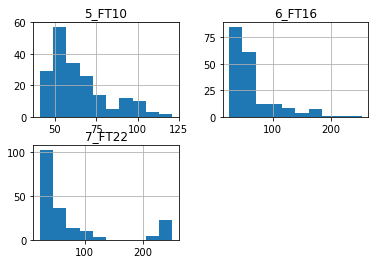

In [12]:
filtered_pheno_df.hist()

# Standard linear regression

As a reminder from the first notebook, the function for standard linear regression in LIMIX is ``limix.qtl.qtl_test_lm`` (see [here](https://limix.readthedocs.io/en/stable/_modules/limix/qtl/qtl.html)).

In [13]:
from limix.qtl import qtl_test_lm

In [14]:
#set parameters for analysis
covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

When you do not include covariates (None), LIMIX still fits an intercept (i.e., ``covs=sp.ones((N,1))``).

In [15]:
# running the analysis
lm = qtl_test_lm(snps=snps.values,pheno=phenotype_std,
                   covs=covs,test=test)
pv_lm = lm.getPv() # 1xS vector of p-values

Convert _P_ values into a DataFrame:

In [16]:
pvalues_lm = pd.DataFrame(data=pv_lm.T,
                          index=positions,
                          columns=pheno_df.columns)

In [17]:
pvalues_lm.describe()

,5_FT10,6_FT16,7_FT22
count,2.145600e+04,2.145600e+04,2.145600e+04
mean,3.391540e-01,3.160295e-01,3.225939e-01
std,3.076493e-01,3.070475e-01,3.092775e-01
min,2.681042e-14,8.060685e-14,3.061920e-15
25%,5.388477e-02,3.373513e-02,3.534523e-02
50%,2.533743e-01,2.175499e-01,2.249094e-01
75%,5.868014e-01,5.550127e-01,5.685764e-01
max,9.999916e-01,9.997372e-01,9.999867e-01


### To get a quick idea of the results from GWAS, visualize the _P_ values with a Manhattan plot

The LIMIX function for producing Manhattan plots is ``limix.plot.plot_manhattan`` (see [here][1]).

[1]:https://limix.readthedocs.io/en/stable/_modules/limix/plot/manhattan.html

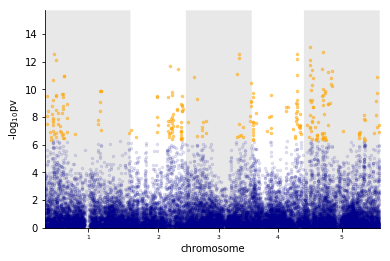

In [18]:
lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lm[phenotype_ID].values,chrom=chromosomes,pos=positions)))

### Why are there so many significant P-values? Let's use QQ plots to compare the distribution of significant P-values to the expected distribution

The function in LIMIX to produce QQ plots is ``limix.plot.qqplot`` (see [here][1]).

[1]:https://limix.readthedocs.io/en/stable/_modules/limix/plot/qqplot.html

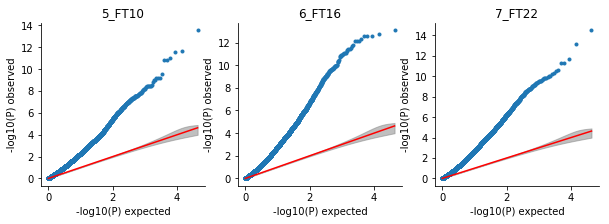

In [19]:
pl.figure(figsize=[10,3])
for ip in range(len(phenotype_names)):
    plt = pl.subplot(1,3,ip+1)
    lmx_plt.qqplot(pvalues_lm[phenotype_names[ip]].values)
    pl.title(phenotype_names[ip])

Question:
* Do you think that all of the significant P-values are reasonable? Is there a problem?






# Accounting for population structure using PCA

One way to account for population structure during GWAS is to add the top principal components (PCs) from PCA of the genotype data as additional covariates.

### Perform principal components analysis (PCA) using sklearn

In [20]:
import sklearn.decomposition.pca as pca
pc = pca.PCA()
pc_snps = pc.fit_transform(snps)

### Plot the top two PCs from PCA of the SNPs
Note that this is a two-dimensional representation of the genotype data

Text(0,0.5,'PCA2')

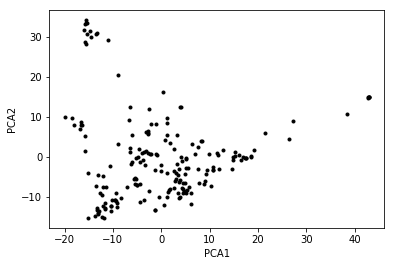

In [21]:
pl.plot(pc_snps[:,0],pc_snps[:,1],'k.')
pl.xlabel('PCA1')
pl.ylabel('PCA2')

### Plot the proportion (%) of variance explained by each PC

Text(0,0.5,'total variance explained')

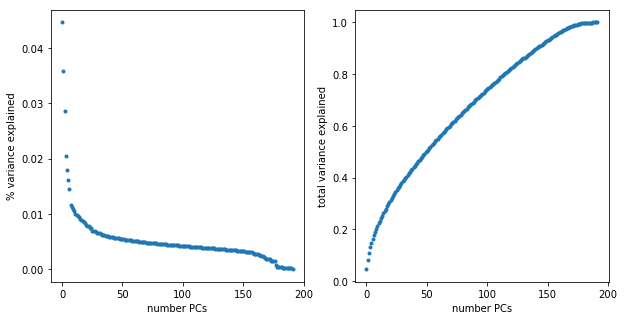

In [22]:
pl.figure(figsize=(10,5))
pl.subplot(1,2,1)
pl.plot(pc.explained_variance_ratio_, ".")
pl.xlabel("number PCs")
pl.ylabel("% variance explained")

pl.subplot(1,2,2)
pl.plot(pc.explained_variance_ratio_.cumsum(), ".")
pl.xlabel("number PCs")
pl.ylabel("total variance explained")

### Running a linear model with PC correction

Here, we perform GWAS using principal components (after PCA of the genotype matrix) in an attempt to correct for confounding due to population structure. Like earlier, we use QQ-plots to check for (possible) P-value inflation.

In [23]:
covs_with_pcs = np.concatenate([np.ones([snps.shape[0],1]),pc_snps],axis=1)
n_components = [0,1,5,10,30]

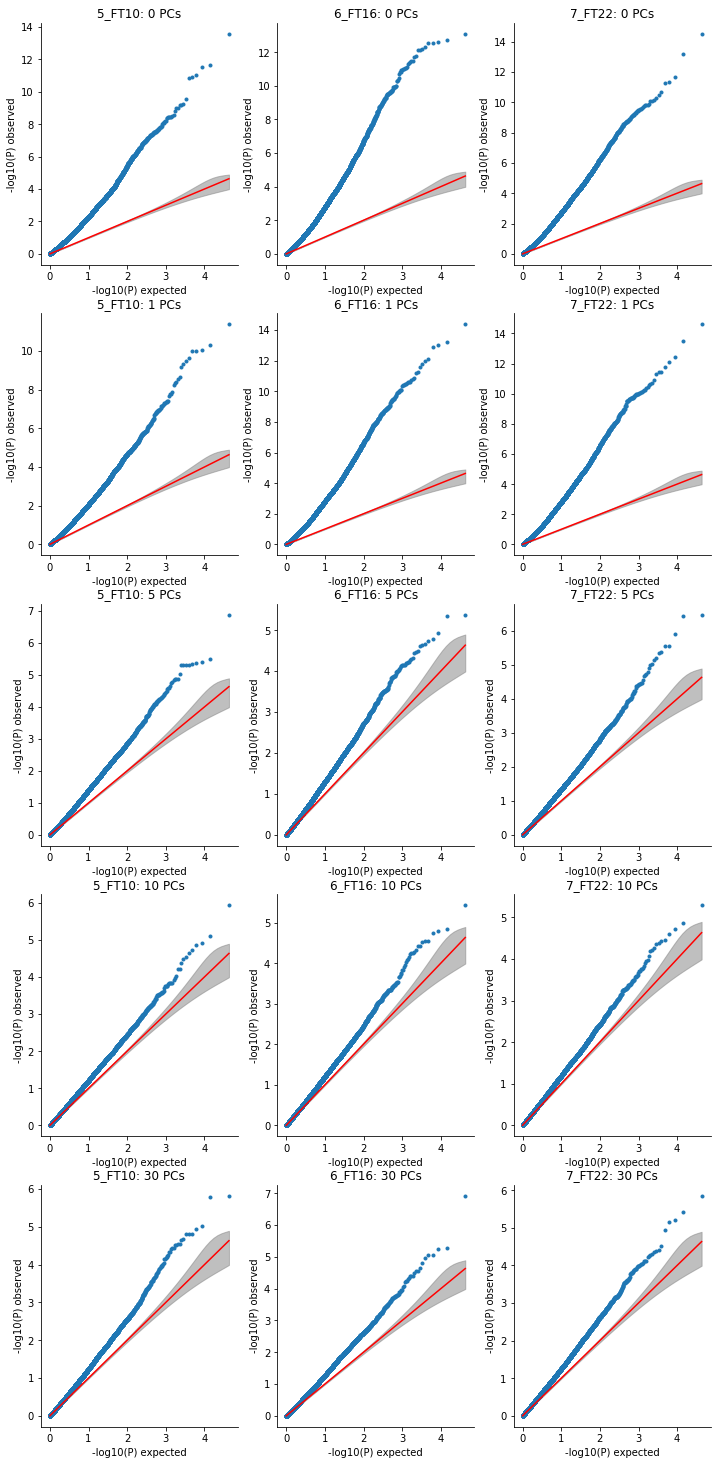

In [24]:
pl.figure(figsize=[12,20])
pl.subplots_adjust(top=1.1)

ip = 1
for i in n_components:

    _covs = covs_with_pcs[:,0:i+1]

    lm = qtl_test_lm(snps=snps.values,pheno=phenotype_std,covs=_covs, test=test)
    
    pvalues_lm = pd.DataFrame(data=lm.getPv().T,
                              index=positions,
                              columns=pheno_df.columns)

    # make qq plot
    for phenotype_ID in phenotype_names:
        plt = pl.subplot(len(n_components),len(phenotype_names),ip)
        lmx_plt.qqplot(pvalues_lm[phenotype_ID].values) 
        ip+=1
        pl.title('%s: %d PCs' % (phenotype_ID,i))

There is still a massive amount of P-value inflation. Can we do better?






# Accounting for population structure using linear mixed models

### Estimate sample relatedness (kinship) using the SNPs

In [25]:
#estimate genetic relatedness
from limix.stats import linear_kinship, gower_norm
sample_relatedness_unnormalized = linear_kinship(snps.values)

100%|██████████| 100/100 [00:00<00:00, 2148.50it/s]


In [26]:
#normalize it
sample_relatedness = gower_norm(sample_relatedness_unnormalized)

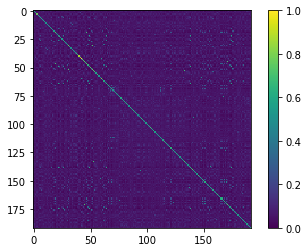

In [27]:
#plot it
from limix.plot import plot_kinship
plot_kinship(sample_relatedness)

### The linear mixed model

In the limix package, one performs GWAS with linear mixed models using the function ``limix.qtl.qtl_test_lmm`` (see [here](https://limix.readthedocs.io/en/stable/qtl.html#linear-mixed-models)).

In [28]:
from limix.qtl import qtl_test_lmm

In [29]:
#settings
covs = None                 #covariates
searchDelta = False         #specify if delta should be optimized for each SNP
test="lrt"                  #specify type of statistical test

In [30]:
#linear mixed model
lmm = qtl_test_lmm(snps=snps.values,
                   pheno=phenotype_std,
                   K=sample_relatedness,
                   covs=covs,
                   test=test)

In [31]:
# retrieve the P-values, the Betas, and the standard errors.
pv_lmm = lmm.getPv() # P values
beta_lmm = lmm.getBetaSNP() # effect sizes
beta_ste_lmm = lmm.getBetaSNPste() # standard errors

Convert the P-values to a pandas DataFrame:

In [32]:
pvalues_lmm = pd.DataFrame(data=pv_lmm.T,
                           index=positions,
                           columns=pheno_df.columns)

### Visualize the P-values from these LMMs using QQ plots

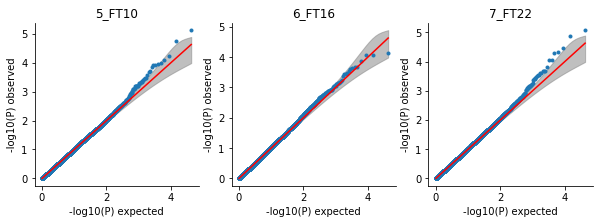

In [33]:
pl.figure(figsize=[10,3])
for ip in range(len(phenotype_names)):
    plt = pl.subplot(1,3,ip+1)
    lmx_plt.qqplot(pvalues_lmm[phenotype_names[ip]].values)
    pl.title(phenotype_names[ip])

### Here, we compare the results from the linear model with the results from the linear mixed-model

For comparison, we (re)fit a linear model.

In [34]:
lm = qtl_test_lm(snps=snps.values,
                 pheno=phenotype_std,
                 covs=covs,
                 test=test)
pvalues_lm = lm.getPv() # 1xS vector of p-values (S=X.shape[1])
pvalues_lm = pd.DataFrame(data=pvalues_lm.T,
                          index=positions,
                          columns=pheno_df.columns)

Text(0.5,1,'LMM')

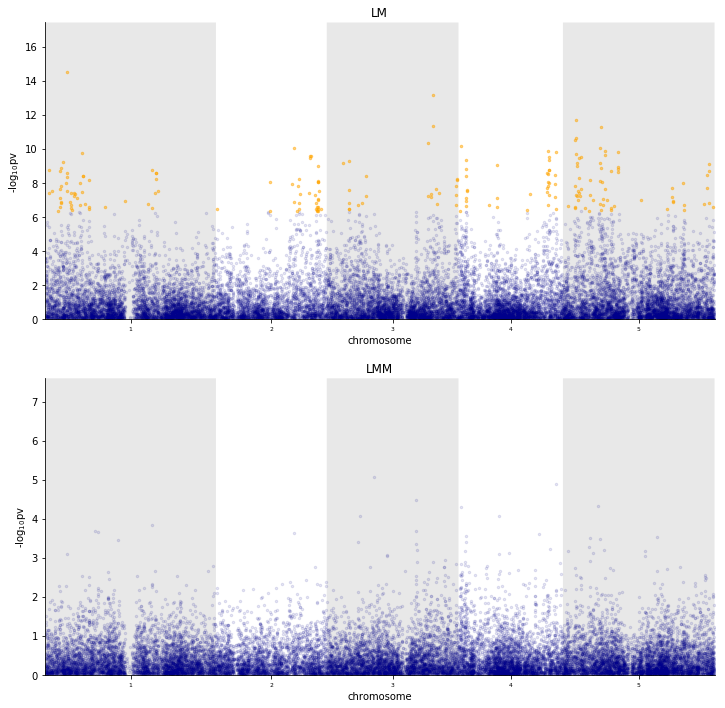

In [35]:
pl.figure(figsize=[12,12])
plt = pl.subplot(2,1,1)
lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lm[phenotype_ID].values,chrom=chromosomes,pos=positions)))
pl.title('LM')
plt = pl.subplot(2,1,2)
lmx_plt.plot_manhattan(pd.DataFrame(dict(pv=pvalues_lmm[phenotype_ID].values,chrom=chromosomes,pos=positions)))
pl.title('LMM')

The _P_ value inflation is gone.